<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [62]:
!pip install pyswmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import extensions

In [63]:
import pandas as pd
import numpy as np
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

In [64]:
for i in range(1, 10):
    with Simulation('example.inp') as sim:
        s1 = Subcatchments(sim)["S1"]
        s1.slope = i

        max = 0
        for step in sim:
            if s1.runoff > max:
                max = s1.runoff
        print(max)
        print(s1.statistics)

1.1017117766835463
{'evaporation': 0.0, 'infiltration': 40.08095092739969, 'peak_runoff_rate': 1.1017117766835463, 'precipitation': 8.333333333333334, 'runoff': 412.5946068003226, 'runon': 0.0}
1.1986211660596646
{'evaporation': 0.0, 'infiltration': 35.82874550923575, 'peak_runoff_rate': 1.1986211660596646, 'precipitation': 8.333333333333334, 'runoff': 419.4945354170769, 'runon': 0.0}
1.244700020136731
{'evaporation': 0.0, 'infiltration': 33.52297295028401, 'peak_runoff_rate': 1.244700020136731, 'precipitation': 8.333333333333334, 'runoff': 421.9438819971835, 'runon': 0.0}
1.2719449053932335
{'evaporation': 0.0, 'infiltration': 31.90571182483301, 'peak_runoff_rate': 1.2719449053932335, 'precipitation': 8.333333333333334, 'runoff': 422.87515938800146, 'runon': 0.0}
1.2900221023880891
{'evaporation': 0.0, 'infiltration': 30.81802602443707, 'peak_runoff_rate': 1.2900221023880891, 'precipitation': 8.333333333333334, 'runoff': 423.20841027569634, 'runon': 0.0}
1.3027692541200493
{'evaporati

In [65]:
def get_slope_data(min_slope=0.05, max_slope=100, file_path='example.inp'):
    slope = []
    runoff = []
    peak_runoff_rate = []
    infiltration = []
    evaporation = []
    runon = []
    s = min_slope
    while s < max_slope:
        slope.append(s)
        with Simulation(file_path) as sim:
            s1 = Subcatchments(sim)["S1"]
            s1.slope = s

            for step in sim:
                pass
                
            stats = s1.statistics
            runoff.append(stats["runoff"])
            peak_runoff_rate.append(stats["peak_runoff_rate"])
            infiltration.append(stats["infiltration"])
            evaporation.append(stats["evaporation"])
            runon.append(stats["runon"])
        s += 0.05
    return {"slope": slope, "runoff": runoff, "peak_runoff_rate": peak_runoff_rate, "infiltration": infiltration, "evaporation": evaporation}

# Manage file to get data to process

# get slope data

In [66]:
data = get_slope_data()

# prepare dataframe

In [67]:
df = pd.DataFrame(data=data)
df.head()

,slope,runoff,peak_runoff_rate,infiltration,evaporation
0,0.05,369.418090,0.641317,65.343830,0.0
1,0.10,379.232016,0.732375,58.171137,0.0
2,0.15,385.221674,0.792551,54.427921,0.0
3,0.20,389.548955,0.837815,51.939255,0.0
4,0.25,392.935795,0.874077,50.113490,0.0


# Plot runoff data

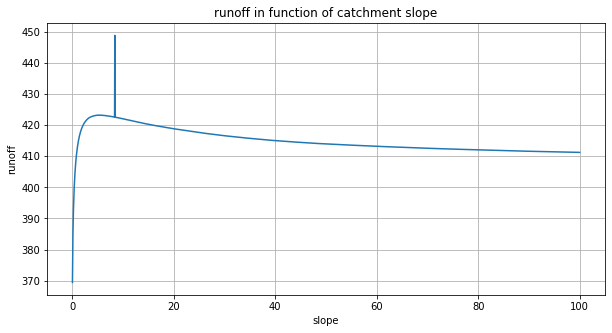

In [68]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['runoff'])
plt.title('runoff in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('runoff')
plt.grid(True)
plt.show()

# Plot peak runoff rate data

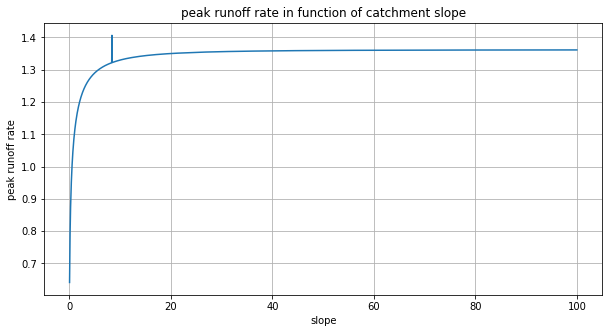

In [69]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['peak_runoff_rate'])
plt.title('peak runoff rate in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('peak runoff rate')
plt.grid(True)
plt.show()

# Plot infiltration data

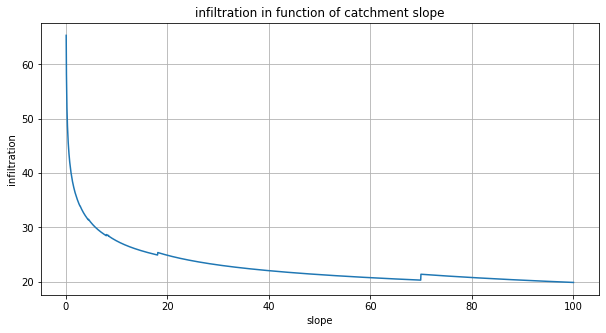

In [70]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['slope'], df['infiltration'])
plt.title('infiltration in function of catchment slope')
plt.xlabel('slope')
plt.ylabel('infiltration')
plt.grid(True)
plt.show()